In [19]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [20]:
import sys, os
import pandas as pd
import numpy as np
from PIL import Image

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D, Dense, Dropout, Activation, Flatten
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils import np_utils


In [21]:
df = pd.read_csv('gdrive/My Drive/emotion_detection/fer2013.csv')
print(df.head())

   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training


convert and show some images from pixels

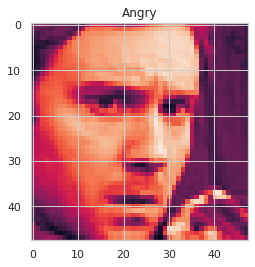

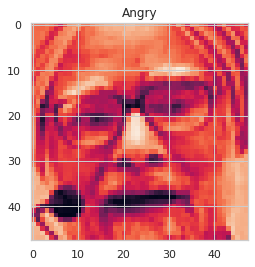

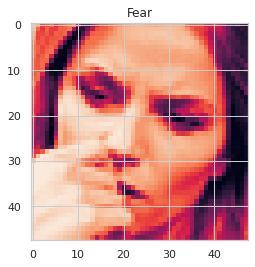

In [63]:
emotions_names = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
df['emotion_name'] = df['emotion'].map(emotions_names)

def convert_pixel2img(emotion, pixels):
  pixels = pixels.split(" ")
  pixels = np.array(pixels, 'float32')
  image = pixels.reshape(48, 48)
  plt.imshow(image, interpolation='nearest')
  plt.title(emotion)
  plt.show()

for i in range(3):
  convert_pixel2img(df['emotion_name'][i], df['pixels'][i])

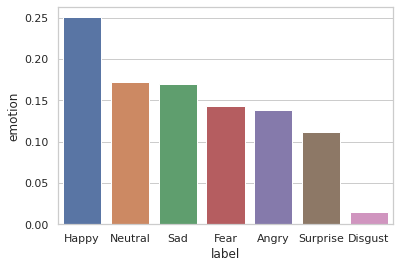

In [5]:
counts = pd.DataFrame(df.emotion.value_counts(normalize=True))
counts['label'] = counts.index.to_series().map(emotion_dict)
ax = sns.barplot(x="label",y='emotion',data=counts)

In [8]:
pixels_values = df.pixels.str.split(" ").tolist()
pixels_values = pd.DataFrame(pixels_values, dtype=int)
images = pixels_values.values
images = images.astype(np.float)

images = images.reshape(images.shape[0], 48, 48, 1)
images = images.astype('float32')

labels_flat = df["emotion"].values.ravel()
labels_count = np.unique(labels_flat).shape[0]

def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[[index_offset + labels_dense.ravel()]] = 1
    return labels_one_hot

labels = dense_to_one_hot(labels_flat, labels_count)
labels = labels.astype(np.uint8)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, shuffle = False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle = False)

In [10]:
##designing the cnn
#1st convolution layer
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1:])))
model.add(Conv2D(64,kernel_size= (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(Dropout(0.5))

#2nd convolution layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(Dropout(0.5))

#3rd convolution layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))

model.add(Flatten())

#fully connected neural networks
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(labels_count, activation='softmax'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 44, 44, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 64)        3

In [18]:
#Compliling the model
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(),
              metrics=['accuracy'])

# Specifying parameters for Data Augmentation
datagen = ImageDataGenerator(

    rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    zoom_range = 0.1)  # zoom images in range [1 - zoom_range, 1+ zoom_range]

datagen.fit(X_train)

history = model.fit_generator(datagen.flow(X_train, y_train,
                    batch_size=32),
                    epochs=200,
                    validation_data=(X_val, y_val),
                    steps_per_epoch=X_train.shape[0]/32
                    #callbacks=[checkpointer,tensorboard]
                             )


#Saving the  model to  use it later on
fer_json = model.to_json()
with open("fer.json", "w") as json_file:
    json_file.write(fer_json)
model.save_weights("fer.h5")


Epoch 1/200
909/908 [==============================] - 13s 14ms/step - loss: 1.4798 - accuracy: 0.4343 - val_loss: 1.3268 - val_accuracy: 0.4960
Epoch 2/200
909/908 [==============================] - 13s 14ms/step - loss: 1.4547 - accuracy: 0.4419 - val_loss: 1.2581 - val_accuracy: 0.5238
Epoch 3/200
909/908 [==============================] - 13s 14ms/step - loss: 1.4374 - accuracy: 0.4516 - val_loss: 1.2605 - val_accuracy: 0.5251
Epoch 4/200
909/908 [==============================] - 12s 14ms/step - loss: 1.4266 - accuracy: 0.4555 - val_loss: 1.3511 - val_accuracy: 0.4901
Epoch 5/200
909/908 [==============================] - 12s 14ms/step - loss: 1.4093 - accuracy: 0.4614 - val_loss: 1.2061 - val_accuracy: 0.5375
Epoch 6/200
909/908 [==============================] - 13s 14ms/step - loss: 1.3920 - accuracy: 0.4701 - val_loss: 1.2859 - val_accuracy: 0.5142
Epoch 7/200
909/908 [==============================] - 12s 14ms/step - loss: 1.3860 - accuracy: 0.4733 - val_loss: 1.2424 - val_ac

In [29]:
scores = model.evaluate(np.array(X_test), np.array(y_test), batch_size=1024)
print("Loss: " + str(scores[0]))
print("Accuracy: " + str(scores[1]))

4/4 [==============================] - 0s 46ms/step - loss: 0.9693 - accuracy: 0.6289
Loss: 0.9693397879600525
Accuracy: 0.6288659572601318


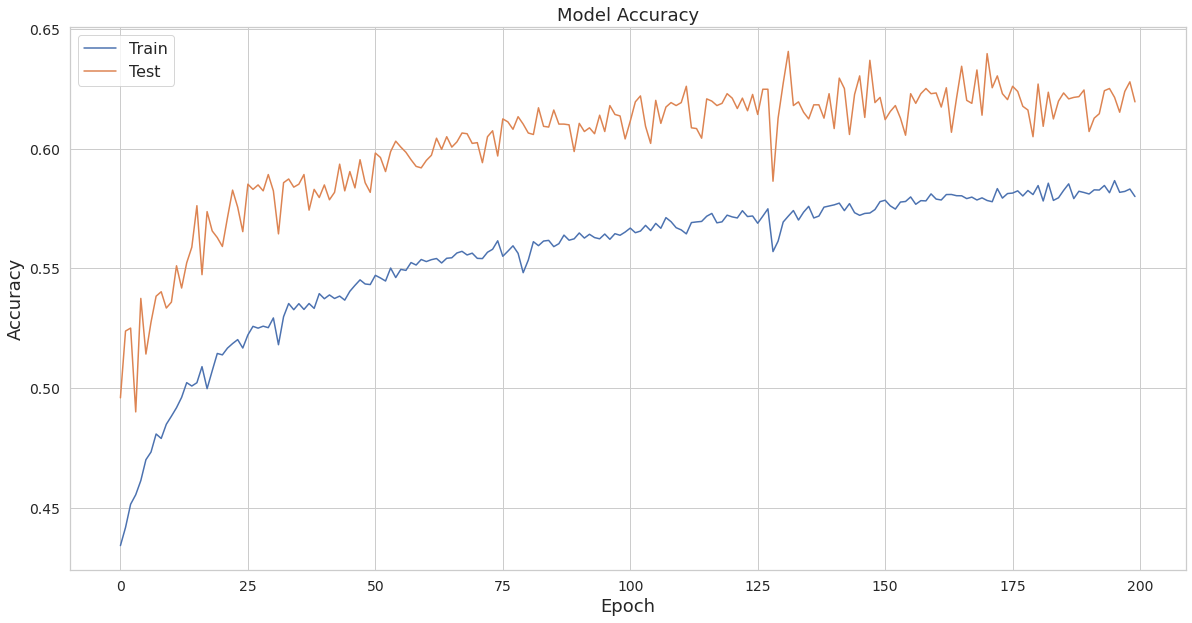

In [34]:
def plot_accuracy(data, size = (20,10)):
    plt.figure(figsize=size) 
    plt.plot(data['accuracy'])
    plt.plot(data['val_accuracy'])
    plt.title('Model Accuracy', fontsize = 18)
    plt.ylabel('Accuracy', fontsize = 18)
    plt.xlabel('Epoch', fontsize = 18)
    plt.legend(['Train', 'Test'], loc='upper left', fontsize = 16)
    plt.tick_params(axis='both', labelsize=14)
    plt.show()
    
plot_accuracy(history.history)

In [35]:
# Function for displaying 15 random images
def show_random(imgs, emotion_nms_org = None, emotion_nms_pred = None, random = True, indices = None):
    """ 

    Function displaying 15 randomly chosen images. Arguments:
    
    imgs:  Source of images
    
    emotion_nms_org: Default "None", if specified, should be a Pandas Series object consisting of emotion names. As a result, emotion name will be displayed above every image.
    
    emotion_nms_pred: Default "None", if specified should be a Pandas Series object with predicted emotion names. As a result, emotion name will be displayed above image.
    
    random: Defult "True", indices will be randomly drawn from “discrete uniform” distribution starting at 0 up to max(len(imgs) otherwise randomly chosen from values passed into "indices" argument without replacement.
    
    indices: Default "None", if specified "random" should be set to "False" to draw random images from the variable passed into "indices" argument starting at min(len(indices)) up to max(len(indices)) and not using "discrete uniform" distribution. 
    
    """
    
    if random == True:
        indices = np.random.randint(0, len(imgs), size = 15)
    else:
        indices = np.random.choice(list(indices), size = 15, replace = False)
    plt.figure(figsize=(20, 14)) 
    for index, number in enumerate(indices):
        plt.subplot(3,5, index + 1)
        if (isinstance(emotion_nms_org, type(None)) & isinstance(emotion_nms_pred, type(None))):
            plt.title('Image: ' + str(indices[index]))           
        elif (isinstance(emotion_nms_org, type(None)) & ~isinstance(emotion_nms_pred, type(None))):
            plt.title('Image: ' + str(indices[index]) + '\n' + 'Predicted emotion:' + emotion_nms_pred[indices[index]])
        elif (~isinstance(emotion_nms_org, type(None)) & isinstance(emotion_nms_pred, type(None))):
             plt.title('Image: ' + str(indices[index]) + '\n' + 'Original emotion: ' + emotion_nms_org[indices[index]])           
        else:
            plt.title('Image: ' + str(indices[index]) + '\n' + 'Original emotion: ' + emotion_nms_org[indices[index]] + 
                      '\n' + 'Predicted emotion:' + emotion_nms_pred[indices[index]])
        show_image = imgs[number].reshape(48,48)
        plt.axis('off')
        plt.imshow(show_image, cmap='gray')

def predict_classes(model, test_imgs, test_labels, emotions_dict,  batch_size  = 32):    

    # Predict class of image using trained model
    class_pred = model.predict(test_imgs, batch_size = batch_size)

    # Convert vector of zeros and ones to label
    labels_pred = np.argmax(class_pred,axis=1)
    true_labels = np.argmax(test_labels, axis=1)

    # Boolean array that indicates whether the predicted label is the true label
    correct = labels_pred == true_labels
    
    # Converting array of labels into emotion names
    pred_emotion_names = pd.Series(labels_pred).map(emotions_dict)
    
    results = {'Predicted_label': labels_pred, 'Predicted_emotion': pred_emotion_names, 'Is_correct' : correct}
    results = pd.DataFrame(results)
    return correct, results


def visualize_predictions(images_test, orglabel_names, predlabel_names, correct_arr, valid = True):
    
    if valid == True:
        correct = np.array(np.where(correct_arr == True))[0]
        # Plot 15 randomly selected and correctly predicted images
        show_random(images_test, emotion_nms_org = orglabel_names, emotion_nms_pred = predlabel_names, random = False, indices = correct)
    else:
        incorrect = np.array(np.where(correct_arr == False))[0]
        # Plot 15 randomly selected and wrongly predicted images
        show_random(images_test, emotion_nms_org = orglabel_names, emotion_nms_pred = predlabel_names, random = False, indices = incorrect)

In [38]:
correct, results_df = predict_classes(model, X_test, y_test, emotions_names, batch_size = 1024)
results_df['Original_label'] = df['emotion'][32298:].values
results_df['True_emotion'] = results_df['Original_label'].map(emotions_names)

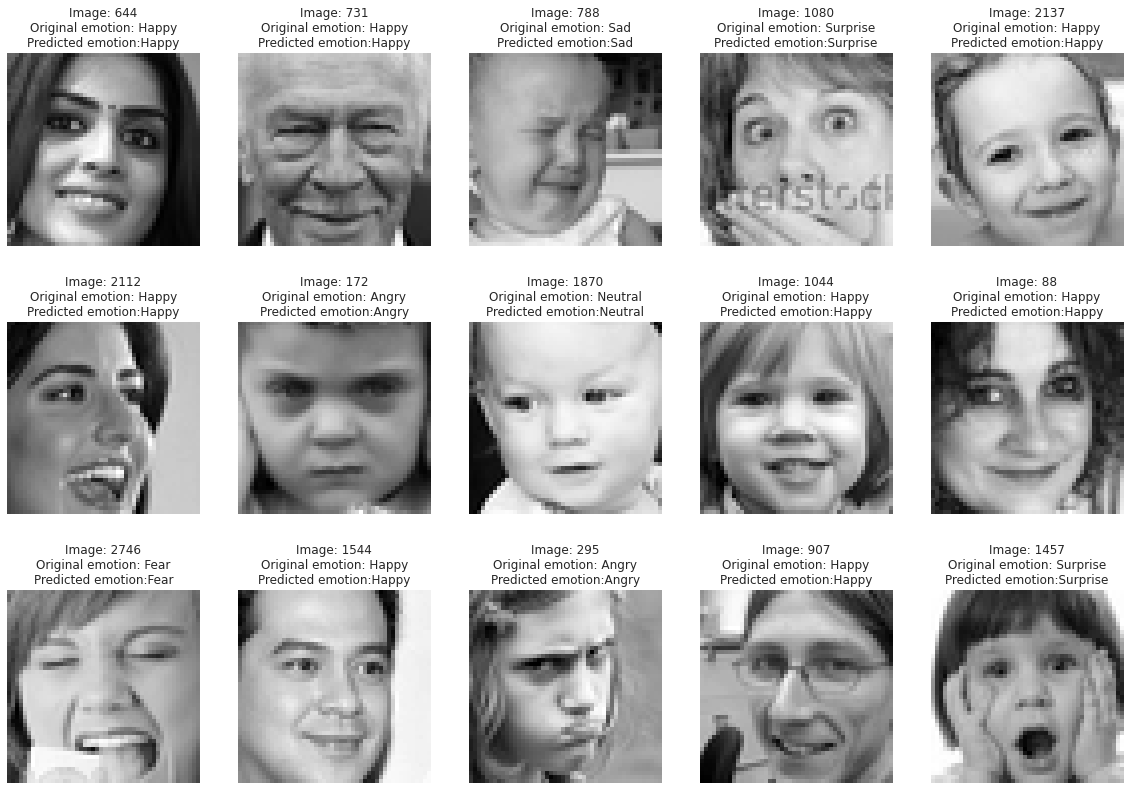

In [41]:
pixels_values = df.pixels.str.split(" ").tolist()
pixels_values = pd.DataFrame(pixels_values, dtype=int)
images = pixels_values.values
images = images.astype(np.float)

test_idx_start = 32298
images_test = images[test_idx_start:]

visualize_predictions(images_test, results_df['True_emotion'], results_df['Predicted_emotion'], correct, valid = True)

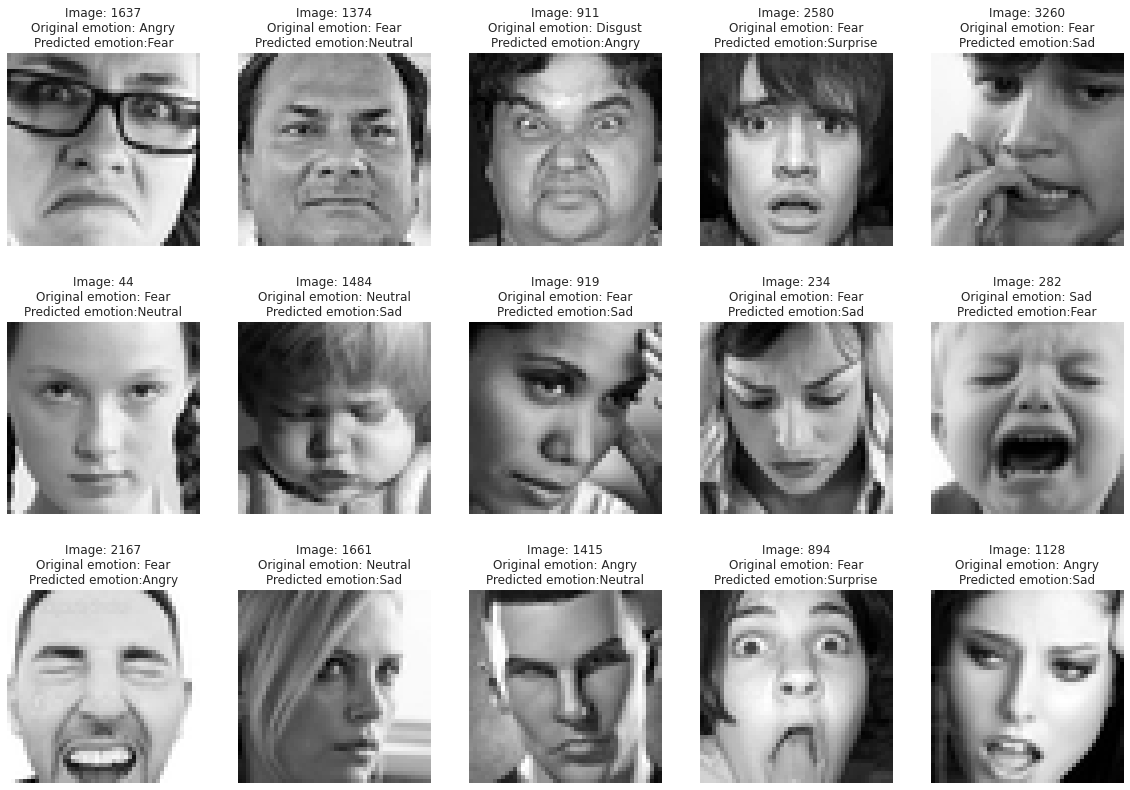

In [42]:
visualize_predictions(images_test, results_df['True_emotion'], results_df['Predicted_emotion'], correct, valid = False)